###  所做的更新
采用滑动窗口的方式按period预测， 最后将结果拼接

删除 16年1，2月份数据

2015.3月的预测值与真实值第二周差异较大，删除这一个月的数据。 预测结果每周中没有下降，比较平缓 predict_0716_rf_drop201503_score_.txt

尝试xgb, 因为语法不一样函数需要调整， 待优化，先提交RF跑出来的结果



In [1]:
% matplotlib inline
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
from sklearn.model_selection import GridSearchCV

In [2]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split


from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import os
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_boston
import xgboost as xgb

In [153]:
# 拆分训练集
train_max_month = 10

# 拆分测试集
test_month = 11
test_day = 30

# model = ExtraTreesRegressor()
# model = RandomForestRegressor()
model = xgb.XGBRegressor()

### 前一天的文件中求的是dow_mean,  这份文件中求dow_diff

In [154]:
df = pd.read_csv("Tianchi_power.csv")

df9 = pd.read_csv("Tianchi_power_9.csv")



df['record_date'] = pd.to_datetime(df['record_date'])
df9['record_date'] = pd.to_datetime(df9['record_date'])
# df9#()

# df.isnull().sum()
# df9.user_id.unique()#.sort_values()#.sum()
# df.shape
# df9.shape
# df.tail()

In [155]:
# # 读入0610最新下载数据做对比 
# df_2 = pd.read_csv("trainset/Tianchi_power.csv")

# df9_2 = pd.read_csv("trainset/Tianchi_power_9.csv")

# df_2['record_date'] = pd.to_datetime(df_2['record_date'])
# df9_2['record_date'] = pd.to_datetime(df9_2['record_date'])
# # df.head()

# df.isnull().sum()
# df9_2.user_id.unique()#.sort_values()#.sum()
# df_2.shape
# df9_2.shape
# # df.tail()

In [156]:
catdf = pd.concat([df,df9])
catdf.shape
catdf.head()
catdf.tail()

,record_date,user_id,power_consumption
43615,2016-09-30,1416,1078059
43616,2016-09-25,1416,1089603
43617,2016-09-26,1416,1089625
43618,2016-09-27,1416,1102526
43619,2016-09-28,1416,1104348


In [157]:
# df_2.loc[ (df_2['record_date'] == '2015-10-04') & (df_2['user_id'] == 431),:]
# df.loc[ (df['record_date'] == '2015-10-04')]
# df_2.loc[  (df_2['user_id'] == 431),:]

(array([ 736209.,  736216.,  736223.,  736230.,  736237.]),
 <a list of 5 Text xticklabel objects>)

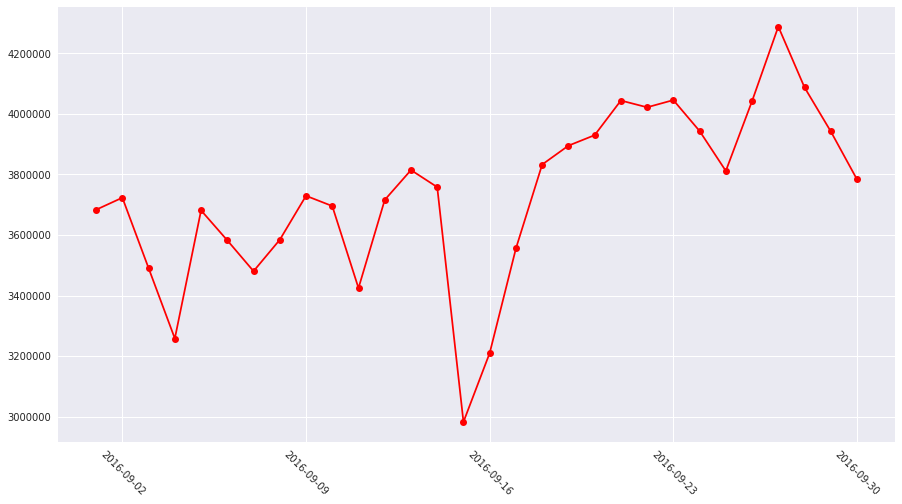

In [158]:
# print('1 ',df9.isnull().sum())
# print('2 ',df9.user_id.unique())
# print('4 ',len(df9.user_id.unique()))
# print('3 ',df.user_id.unique())
# print('5 ',len(df.user_id.unique()))


df9_tmp = df9[['record_date','power_consumption']].groupby(by='record_date').agg('sum')
df9_tmp = df9_tmp.reset_index()
df9_tmp.head()
df9_tmp.shape

import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.plot(df9_tmp['record_date'], df9_tmp['power_consumption'], '-ro')
# plt.setp(labels, rotation=90)
plt.xticks(rotation=-45)
# plt.show()

### 填充缺省值

In [159]:
dates = pd.date_range("2015-01-01","2016-09-30", freq="1D")
userid = pd.DataFrame({'user_id':df['user_id'].unique()})
dates = pd.DataFrame(dates)
dates.columns = ['record_date']
userid['key'] = 0
dates['key'] = 0
full = userid.merge(dates, how='left', on = 'key')
full.drop('key',1, inplace=True)
full.head(2)

,user_id,record_date
0,1,2015-01-01
1,1,2015-01-02


In [160]:
df.isnull().sum()
catdf.shape

(929088, 3)

In [161]:
df = pd.merge(full, catdf, how='left', on=['user_id','record_date'])
df['power_consumption'] = df['power_consumption'].interpolate()
df.shape

(929106, 3)

In [162]:
639*1454

929106

In [163]:
df.head(15)

,user_id,record_date,power_consumption
0,1,2015-01-01,1135.0
1,1,2015-01-02,570.0
2,1,2015-01-03,3418.0
3,1,2015-01-04,3968.0
4,1,2015-01-05,3986.0
5,1,2015-01-06,4082.0
6,1,2015-01-07,4172.0
7,1,2015-01-08,4022.0
8,1,2015-01-09,4025.0
9,1,2015-01-10,4047.0


In [164]:
# df[['record_date','power_consumption']].groupby(by='record_date').agg('sum')

### 用电量聚合到一个月

In [165]:
### 用电量聚合到一个月

base_df = df[['record_date','power_consumption']].groupby(by='record_date').agg('sum')
base_df = base_df.reset_index()
base_df.head()
base_df.shape
# df = base_df

(639, 2)

### 并入10月份的数据

In [166]:
df10 = pd.read_csv("Tianchi_power_10.csv")
base_df = pd.concat([base_df, df10])
df10

,record_date,power_consumption
0,2016/10/1,3083354
1,2016/10/2,3123510
2,2016/10/3,3334518
3,2016/10/4,3667928
4,2016/10/5,3799292
5,2016/10/6,3835720
6,2016/10/7,3871576
7,2016/10/8,3819638
8,2016/10/9,3702715
9,2016/10/10,3863058


(array([ -5.,   0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.]),
 <a list of 9 Text xticklabel objects>)

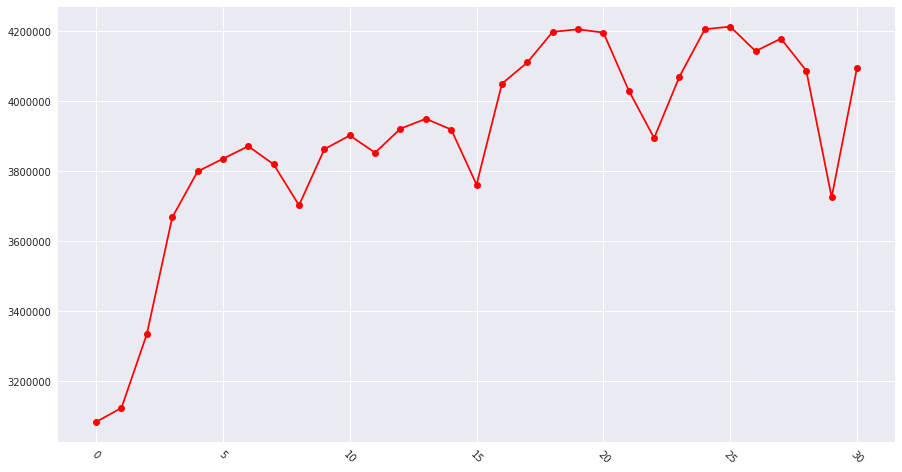

In [167]:

plt.figure(figsize=(15,8))
plt.plot(range(df10.shape[0]), df10['power_consumption'], '-ro')
# plt.setp(labels, rotation=90)
plt.xticks(rotation=-45)
# plt.show()

,record_date,power_consumption
0,2015-01-01 00:00:00,2900575.0
1,2015-01-02 00:00:00,3158211.0
2,2015-01-03 00:00:00,3596487.0
3,2015-01-04 00:00:00,3939672.0
4,2015-01-05 00:00:00,4101790.0


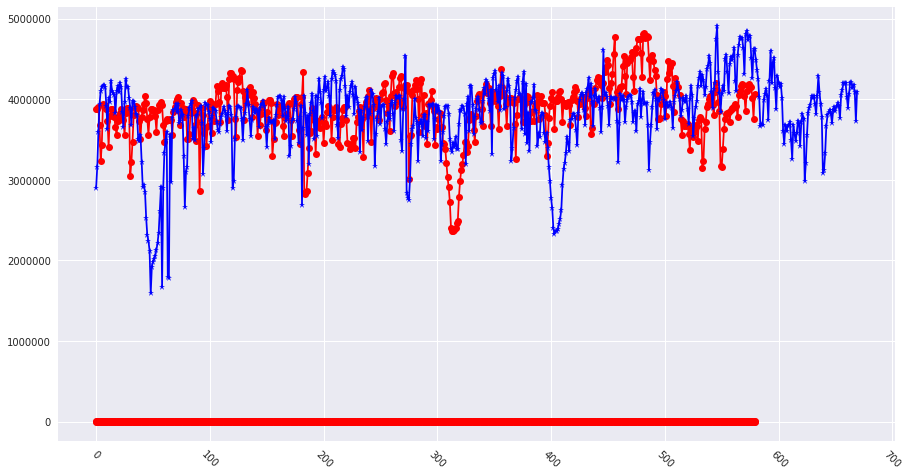

In [168]:
t = pd.read_csv('train/predict_train_30.csv')
plt.figure(figsize=(15,8))
plt.plot(range(t.shape[0]), t, '-ro')
# plt.setp(labels, rotation=90)
plt.plot(range(base_df.shape[0]),base_df['power_consumption'],'-b*')

plt.xticks(rotation=-45)
# plt.show()
t.head()
base_df.head()

In [169]:
base_df['record_date'] = pd.to_datetime(base_df['record_date'])
base_df.tail()



,record_date,power_consumption
26,2016-10-27,4143220.0
27,2016-10-28,4179198.0
28,2016-10-29,4087537.0
29,2016-10-30,3725423.0
30,2016-10-31,4095859.0


In [170]:
base_df = base_df.reset_index()
base_df = base_df.drop('index',1)
base_df.info()
base_df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 2 columns):
record_date          670 non-null datetime64[ns]
power_consumption    670 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.5 KB


,record_date,power_consumption
665,2016-10-27,4143220.0
666,2016-10-28,4179198.0
667,2016-10-29,4087537.0
668,2016-10-30,3725423.0
669,2016-10-31,4095859.0


### 拼接测试集

In [171]:
df_test = base_df[(base_df.record_date>='2016-09-01')&(base_df.record_date<='2016-09-30')]
df_test['record_date'] = pd.DataFrame(df_test['record_date']+pd.Timedelta('61 days'))
# df_test#.shape#head()

###############   ignore_index=True 这个参数非常重要， 它使用concat时 reset row index. 
base_df = pd.concat([base_df, df_test], ignore_index=True)#.sort_values(['record_date'])
# base_df.shape
base_df = base_df.reset_index()
base_df = base_df.drop('index',1)
# df = base_df
base_df.tail()#.shape

,record_date,power_consumption
695,2016-11-26,4042132.0
696,2016-11-27,4287965.0
697,2016-11-28,4086998.0
698,2016-11-29,3941842.0
699,2016-11-30,3783264.0


In [172]:
# df_test

In [173]:
# df.head()
# df.tail(60)#.shape#.isnull().sum()

### 造特征

### doy, dow ...

In [174]:
# base_df['dow'] = base_df['record_date'].apply(lambda x: x.dayofweek)
# base_df['doy'] = base_df['record_date'].apply(lambda x: x.dayofyear)
# base_df['day'] = base_df['record_date'].apply(lambda x: x.day)
# base_df['month'] = base_df['record_date'].apply(lambda x: x.month)
# base_df['year'] = base_df['record_date'].apply(lambda x: x.year)
# base_df = df
# df.head()
df.shape

base_df['year'] = pd.DatetimeIndex(base_df.record_date).year
base_df['month'] = pd.DatetimeIndex(base_df.record_date).month#dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
base_df['day'] = pd.DatetimeIndex(base_df.record_date).day
base_df['dow'] = pd.DatetimeIndex(base_df.record_date).dayofweek
base_df['doy'] = pd.DatetimeIndex(base_df.record_date).dayofyear

def map_season(month):
    month_dic = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:3, 9:3, 10:4, 11:4, 12:1}
    return month_dic[month]

base_df['season'] = base_df['month'].apply(lambda x: map_season(x))
base_df.head()

,record_date,power_consumption,year,month,day,dow,doy,season
0,2015-01-01,2900575.0,2015,1,1,3,1,1
1,2015-01-02,3158211.0,2015,1,2,4,2,1
2,2015-01-03,3596487.0,2015,1,3,5,3,1
3,2015-01-04,3939672.0,2015,1,4,6,4,1
4,2015-01-05,4101790.0,2015,1,5,0,5,1


    
    ## outliers!

{'boxes': [<matplotlib.lines.Line2D at 0x7fdd967692d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7fdd96434c50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fdd964ea650>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fdd964ea2d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fdd966b3c90>,
  <matplotlib.lines.Line2D at 0x7fdd96724e50>]}

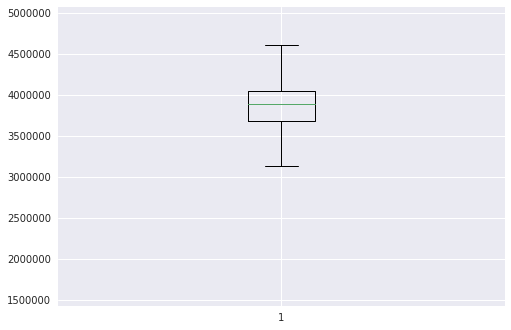

In [175]:
# from matplotlib.pyplot import 
plt.boxplot(base_df['power_consumption'])

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


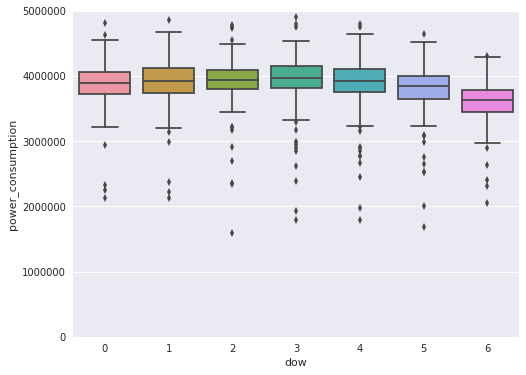

In [176]:
#box plot overallqual/saleprice
var = 'dow'
data = pd.concat([base_df['power_consumption'], base_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="power_consumption", data=data)
fig.axis(ymin=0, ymax=5000000);

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


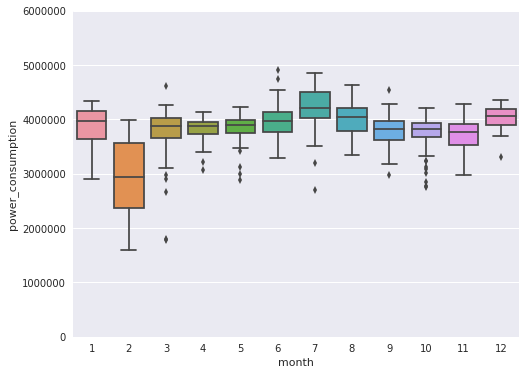

In [177]:
#box plot overallqual/saleprice
var = 'month'
data = pd.concat([base_df['power_consumption'], base_df['month']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="power_consumption", data=data)
fig.axis(ymin=0, ymax=6000000);

### 造特征  添加特征 是否为法定假日

In [178]:

# feature = pd.read_csv("feature/feature_isworkday.csv")
isholiday = pd.read_csv('feature/feature_isholiday.csv')
# feature.shape

# pd.merge(base_df, feature, how='left', on='record_date')
# feature
# base_df['isworkday'] = feature['isworkday'].values

base_df['isholiday'] = isholiday['isholiday'].values
# base_df.tail(60)

In [179]:
def setworkday(dow):
    if dow == 5 or dow == 6:
        return 0
    else:
        return 1
base_df['isworkday'] = base_df['dow'].apply(setworkday)

base_df.tail(6)

,record_date,power_consumption,year,month,day,dow,doy,season,isholiday,isworkday
694,2016-11-25,3811406.0,2016,11,25,4,330,4,0,1
695,2016-11-26,4042132.0,2016,11,26,5,331,4,0,0
696,2016-11-27,4287965.0,2016,11,27,6,332,4,0,0
697,2016-11-28,4086998.0,2016,11,28,0,333,4,0,1
698,2016-11-29,3941842.0,2016,11,29,1,334,4,0,1
699,2016-11-30,3783264.0,2016,11,30,2,335,4,0,1


In [180]:
# train = base_df
# train.head()

### 添加特征  

### 造特征  添加特征假日的用电量

In [181]:
# 找出所有dow = not (5 or 6) and isworkday = 0 的索引
# 造特征 holiday_usage


In [182]:
# # isholiday = pd.read_csv('feature/feature_isholiday.csv')
# # 
# # 复制 用量量那一列的数据
# base_df['holiday_usage'] = base_df['power_consumption']
# # # 将不是holiday的赋值为0
# base_df.loc[base_df[base_df.isholiday==0].index ,'holiday_usage'] = 0

# # # 整个10月先置为0
# base_df.loc[base_df[base_df.record_date>='2016-10-01'].index ,'holiday_usage'] = 0
# # base_df.shape

# # # 特殊处理16年国庆7天的数据
# # # 再用15年国庆的值赋值
# # base_df.loc[base_df[base_df.record_date>='2016-10-01'].index ,'holiday_usage'] = 0
# # # base_df[(base_df.record_date>='2015-10-01') & (base_df.record_date<='2015-10-07')]['holiday_usage'].values
# # # base_df.loc[base_df[(base_df.record_date>='2016-10-01') & (base_df.record_date<='2016-10-07')].index ,'holiday_usage'] = base_df[(base_df.record_date>='2015-10-01') & (base_df.record_date<='2015-10-07')].shift(365)
# base_df.loc[base_df[(base_df.record_date>='2016-10-01') & (base_df.record_date<='2016-10-07')].index ,'holiday_usage'] = base_df[(base_df.record_date>='2015-10-01') & (base_df.record_date<='2015-10-07')]['holiday_usage'].values
# # # power_consumption
# train['holiday_usage'] = base_df['holiday_usage']
# # train = pd.merge(train, base_df, how='left', on=['year','month','dow'])
# # # base_df.loc[base_df[(base_df.record_date=='2016-10-01')].index,'holiday_usage'] = base_df.loc[base_df[(base_df.record_date>='2015-10-01')]]['power_consumption']
# base_df.head()#.shape#.tail(60)#.head()


In [183]:
# base_df[base_df.record_date<'2016-01-01']['power_consumption']
# base_df[base_df.record_date<'2016-01-01'].index
# train.isnull().sum()

### 造特征  添加特征 依照每月 dow 求均值 dow_mean

In [184]:
### workday 的处理： 比如今天是周三，就用上个月的所有周三的均值来填充
# mean_dow = 
df_stats = base_df[['year','month','dow','power_consumption']].groupby(by=['year','month','dow']).agg(['mean'])
df_stats.columns = df_stats.columns.droplevel(0)
df_stats = df_stats.reset_index()
df_stats['mean'] = df_stats['mean'].diff(1)
df_stats = df_stats.rename(index=str,columns={'mean':'dow_mean'})
# df_stats['dow_mean'] = df_stats['dow_mean'].diff(1)
df_stats.head()
## df_stats['dow_mean'] = df_stats['mean'].diff(1)
# df_stats['dow_mean'] = df_stats['mean'].shift(7)
df_stats = df_stats.drop('dow',1)
df_stats = df_stats[['year','month','dow_mean']].groupby(by=['year','month']).agg(lambda x: ",".join(x.apply(str).values.tolist()))
df_stats = df_stats.reset_index()

# ## df_stats['dow_mean'].str.split(',', expand=True) 
df_stats[['dow_mean_0','dow_mean_1','dow_mean_2','dow_mean_3','dow_mean_4','dow_mean_5','dow_mean_6']] =  df_stats['dow_mean'].str.split(',', expand=True) 
df_stats = df_stats.drop('dow_mean',1)
df_stats[['dow_mean_0','dow_mean_1','dow_mean_2','dow_mean_3','dow_mean_4','dow_mean_5','dow_mean_6']] = df_stats[['dow_mean_0','dow_mean_1','dow_mean_2','dow_mean_3','dow_mean_4','dow_mean_5','dow_mean_6']].shift(1)
## month_period_df
df_stats

base_df = pd.merge(base_df, df_stats, how='left', on=['year','month'])
base_df.head()


,record_date,power_consumption,year,month,day,dow,doy,season,isholiday,isworkday,dow_mean_0,dow_mean_1,dow_mean_2,dow_mean_3,dow_mean_4,dow_mean_5,dow_mean_6
0,2015-01-01,2900575.0,2015,1,1,3,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,3158211.0,2015,1,2,4,2,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,3596487.0,2015,1,3,5,3,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,3939672.0,2015,1,4,6,4,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,4101790.0,2015,1,5,0,5,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [185]:
### workday 的处理： 比如今天是周三，就用上个月的所有周三的均值来填充
# mean_dow = 
df_stats = base_df[['year','month','dow','power_consumption']].groupby(by=['year','month','dow']).agg(['mean'])
df_stats.columns = df_stats.columns.droplevel(0)
df_stats = df_stats.reset_index()
df_stats['mean'] = df_stats['mean'].diff(1)
df_stats = df_stats.rename(index=str,columns={'mean':'dow_mean'})
# df_stats['dow_mean'] = df_stats['dow_mean'].diff(1)
df_stats.head()
# df_stats['dow_mean'] = df_stats['mean'].diff(1)
df_stats['dow_mean'] = df_stats['dow_mean'].shift(7)
# df_stats = df_stats.drop('dow',1)
# df_stats = df_stats[['year','month','dow_mean']].groupby(by=['year','month']).agg(lambda x: ",".join(x.apply(str).values.tolist()))
# df_stats = df_stats.reset_index()

# # ## df_stats['dow_mean'].str.split(',', expand=True) 
# df_stats[['dow_mean_0','dow_mean_1','dow_mean_2','dow_mean_3','dow_mean_4','dow_mean_5','dow_mean_6']] =  df_stats['dow_mean'].str.split(',', expand=True) 
# df_stats = df_stats.drop('dow_mean',1)
# df_stats[['dow_mean_0','dow_mean_1','dow_mean_2','dow_mean_3','dow_mean_4','dow_mean_5','dow_mean_6']] = df_stats[['dow_mean_0','dow_mean_1','dow_mean_2','dow_mean_3','dow_mean_4','dow_mean_5','dow_mean_6']].shift(1)
# ## month_period_df
df_stats

base_df = pd.merge(base_df, df_stats, how='left', on=['year','month','dow'])
base_df
# base_df.head()
# base_df.isnull().sum()

,record_date,power_consumption,year,month,day,dow,doy,season,isholiday,isworkday,dow_mean_0,dow_mean_1,dow_mean_2,dow_mean_3,dow_mean_4,dow_mean_5,dow_mean_6,dow_mean
0,2015-01-01,2900575.0,2015,1,1,3,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,3158211.0,2015,1,2,4,2,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,3596487.0,2015,1,3,5,3,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,3939672.0,2015,1,4,6,4,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,4101790.0,2015,1,5,0,5,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2015-01-06,4149164.0,2015,1,6,1,6,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2015-01-07,4161928.0,2015,1,7,2,7,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2015-01-08,4182622.0,2015,1,8,3,8,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2015-01-09,4153509.0,2015,1,9,4,9,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2015-01-10,3913704.0,2015,1,10,5,10,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### holiday_usage_diff

In [186]:
# # 
# # isholiday = pd.read_csv('feature/feature_isholiday.csv')

# # 将数据平移 365天， 
# base_df['dayshift'] = base_df['power_consumption'].shift(365) 
# # 15年取自己本身的值
# base_df.loc[base_df[base_df.record_date<'2016-01-01'].index, 'dayshift'] = base_df[base_df.record_date<'2016-01-01']['power_consumption']
# #
# train['holiday_usage_diff'] = base_df['dayshift'] * base_df['isholiday']
# train['holiday_usage_diff'] = train['holiday_usage_diff'].diff(1)
# # train = train.drop('dayshift',1)
# # base = base_df[['record_date','holiday_usage_diff']]
# # base

# # train['holiday_usage'] = base_df['holiday_usage']#pd.merge(train, base, how='left', on=['record_date'])


### holiday_usage

In [187]:
# # 
# # isholiday = pd.read_csv('feature/feature_isholiday.csv')

# # 将数据平移 365天， 
# # base_df['dayshift'] = base_df['power_consumption'].shift(366) 
# # 15年取自己本身的值
# # base_df.loc[base_df[base_df.record_date<'2016-01-01'].index, 'dayshift'] = base_df[base_df.record_date<'2016-01-01']['power_consumption']
# #
# train['holiday_usage'] = base_df['dayshift'] * base_df['isholiday']
# # train['holiday_usage_diff'] = train['holiday_usage_diff'].diff(1)
# # train = train.drop('dayshift',1)
# # base = base_df[['record_date','holiday_usage_diff']]
# # base

# # train['holiday_usage'] = base_df['holiday_usage']#pd.merge(train, base, how='left', on=['record_date'])


In [188]:
# train.isnull().sum()
# train[train.record_date>='2016-01-01'].count()
# train[train.record_date>='2016-02-01']

### day shift  16年的数据参考15年的值

In [189]:
# # 
# # isholiday = pd.read_csv('feature/feature_isholiday.csv')

# # 将数据平移 365天， 
# base_df['dayshift'] = base_df['power_consumption'].shift(366) 

# # base_df.loc[base_df[base_df.record_date>='2016-02-01' & base_df.record_date<'2016-03-01'].index, 'dayshift'] = base_df[base_df.record_date < '2015-01-01']['power_consumption']
# # 15年取自己本身的值
# base_df.loc[base_df[base_df.record_date<'2016-03-01'].index, 'dayshift'] = base_df[base_df.record_date<'2016-03-01']['power_consumption']
# #
# # train['holiday_usage_diff'] = base_df['dayshift'] * base_df['isholiday']
# # train['holiday_usage_diff'] = train['holiday_usage_diff'].diff(1)
# # train = train.drop('dayshift',1)
# # base = base_df[['record_date','holiday_usage_diff']]
# # base
# train['dayshift'] = base_df['dayshift']
# # train['holiday_usage'] = base_df['holiday_usage']#pd.merge(train, base, how='left', on=['record_date'])
# train.head()
# # train.isnull().sum()

In [190]:
# 查看是否将 15年的记录平移到了16年
# base_df[base_df.record_date > '2016-09-30'  ]
# base.head()
# base_df[base_df.record_date<'2016-01-01']['power_consumption']

In [191]:
# train[train.record_date > '2015-09-30'  ]
# base.head()
# base_df[base_df.record_date<'2016-01-01']['power_consumption']

### 造特征  添加特征 dow_diff

In [192]:
# ### workday 的处理： 比如今天是周三，就用上个月的所有周三的均值来填充
# # mean_dow = 
# df_stats = base_df[['year','month','dow','power_consumption']].groupby(by=['year','month','dow']).agg(['mean'])
# df_stats.columns = df_stats.columns.droplevel(0)
# df_stats = df_stats.reset_index()
# df_stats.head()
# df_stats['dow_diff'] = df_stats['mean'].diff(1)
# df_stats['dow_diff'] = df_stats['dow_diff'].shift(7)
# df_stats = df_stats.drop('mean',1)
# # df_stats['2_m_mean'] = df_stats['mean'].shift(2)
# # df_stats['std'] = df_stats['std'].shift(1)
# # df_stats['2_m_std'] = df_stats['std'].shift(2)
# df_stats#.head()   # 

# train = pd.merge(train, df_stats, how='left', on=['year','month','dow'])


In [193]:
# train.head()

### dow_diff 与 holiday_usage_diff 合并

In [194]:
# # 
# holidayidx = base_df[base_df['isholiday'] == 1].index
# train['holiday_workday_diff'] = train['dow_diff']
# train.loc[holidayidx, 'holiday_workday_diff'] = train.loc[holidayidx,'holiday_usage_diff']
# # train = train.drop(['holiday_usage_diff','dow_diff'],1)
# train = train.drop(['holiday_usage_diff'],1)

# train.tail(30)
# # 此列数据还未与holiday_usage 列合并
# # base_df['holiday_usage'] = (base_df['holiday_usage']) * df_stats['mean']

### workday_mean， 按月区分 holiday and workday, 求均值，分别赋值
# 这个特征不能加， 拉低后3周的值， 得分不高

In [195]:
# # 按月区分 holiday and workday, 求均值，分别赋值

# ### workday 的处理： 比如今天是周三，就用上个月的所有周三的均值来填充
# # mean_dow = 
# df_stats = base_df[['year','month','isworkday','power_consumption']].groupby(by=['year','month','isworkday']).agg(['mean'])
# df_stats.columns = df_stats.columns.droplevel(0)
# df_stats = df_stats.reset_index()
# df_stats.head()
# df_stats['holiday_workday_mean'] = df_stats['mean'].shift(2)#.diff(1)
# # df_stats['dow_mean'] = df_stats['dow_mean'].shift(7)

# train = pd.merge(train, df_stats, how='left', on=['year','month','isworkday'])


In [196]:
# base_df#.isnull().sum()
# train.tail(60)

### 
### 用电量平移

### 
### 添加前一个月的均值和方差

In [197]:
# base_df.head()
base_df.power_consumption.mean()

3806912.212857143

In [198]:
df_stats = base_df[['power_consumption','year','month']].groupby(by=['year', 'month']).agg(['mean', 'std'])
df_stats.head()

df_stats.columns = df_stats.columns.droplevel(0)
df_stats = df_stats.reset_index()
df_stats.head()
df_stats['mean'] = df_stats['mean'].shift(1)
# df_stats['2_m_mean'] = df_stats['mean'].shift(2)
df_stats['std'] = df_stats['std'].shift(1)
# df_stats['2_m_std'] = df_stats['std'].shift(2)
df_stats.head()

# train = pd.merge('base_df','df_stats',on=['year','month'])
base_df = pd.merge(base_df, df_stats, how='left', on=['year','month'])
# train.head(60)

In [199]:
# train.head()

### 把一个月分成上下 半月
### 用它们的均值之差表示数据上下起伏趋势

In [200]:
# 先对一个月做切分
def month_half(day):
    if day>=1 and day<=15:
        return 1
    else:
        return 2

base_df['biweek_period'] = base_df['day'].apply(lambda x:month_half(x))
# base_df['week_period'] = base_df['day'].apply(lambda x:week_period(x))

# mean_dow = 
df_stats = base_df[['year','month','biweek_period','power_consumption']].groupby(by=['year','month','biweek_period']).agg(['mean'])
df_stats.columns = df_stats.columns.droplevel(0)
df_stats = df_stats.reset_index()
df_stats['mean'] = df_stats['mean'].diff(1)
df_stats = df_stats.drop('biweek_period',1)
df_stats = df_stats.rename(index=str,columns={'mean':'biweek_period'})

# ## df_stats['dow_mean'] = df_stats['mean'].diff(1)
# # df_stats['dow_mean'] = df_stats['mean'].shift(7)
# # df_stats = df_stats.drop('dow',1)
df_stats = df_stats[['year','month','biweek_period']].groupby(by=['year','month']).agg(lambda x: ",".join(x.apply(str).values.tolist()))
df_stats = df_stats.reset_index()

# # ## df_stats['dow_mean'].str.split(',', expand=True) 
df_stats[['biweek_period_0','biweek_period_1']] =  df_stats['biweek_period'].str.split(',', expand=True) 
df_stats = df_stats.drop('biweek_period',1)
df_stats[['biweek_period_0','biweek_period_1']] = df_stats[['biweek_period_0','biweek_period_1']].shift(1)
# ## month_period_df
df_stats

base_df = pd.merge(base_df, df_stats, how='left', on=['year','month'])
base_df.head()



,record_date,power_consumption,year,month,day,dow,doy,season,isholiday,isworkday,...,dow_mean_3,dow_mean_4,dow_mean_5,dow_mean_6,dow_mean,mean,std,biweek_period,biweek_period_0,biweek_period_1
0,2015-01-01,2900575.0,2015,1,1,3,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
1,2015-01-02,3158211.0,2015,1,2,4,2,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
2,2015-01-03,3596487.0,2015,1,3,5,3,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
3,2015-01-04,3939672.0,2015,1,4,6,4,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
4,2015-01-05,4101790.0,2015,1,5,0,5,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN


### 把一个月分成上中下旬3个month_periods 或者 4周总共4个week_periods
### 用它们的均值之差表示数据上下起伏趋势

In [201]:
# 先对一个月做切分
def month_period(day):
    if day>=1 and day<=10:
        return 1
    elif day>=11 and day<=20:
        return 2
    else:
        return 3

def week_period(day):
    if day>=1 and day<=7:
        return 1
    elif day>=8 and day<=14:
        return 2
    elif day>=15 and day<=21:
        return 3
    else:
        return 4

base_df['month_period'] = base_df['day'].apply(lambda x:month_period(x))
base_df['week_period'] = base_df['day'].apply(lambda x:week_period(x))

### 按照period求均值

In [202]:
month_period_df = base_df[['power_consumption','year','month','month_period']].groupby(by=['year', 'month', 'month_period']).agg('mean')
month_period_df = month_period_df.reset_index()
# month_period_df.head(30)

### 求出来均值之差

In [203]:
month_period_df['month_period'] = month_period_df['power_consumption'].diff(1)
month_period_df = month_period_df.drop('power_consumption',1)
# month_period_df.head(30)

### 填充上个月和上上个月的趋势数据

In [204]:
month_period_df = month_period_df[['year','month','month_period']].groupby(by=['year','month']).agg(lambda x: ",".join(x.apply(str).values.tolist()))
month_period_df = month_period_df.reset_index()
month_period_df[['month_period_1','month_period_2','month_period_3']] =  month_period_df['month_period'].str.split(',', expand=True) 
month_period_df = month_period_df.drop('month_period',1)

# # # month_1_columns = [tmp+'_1month' for tmp in ['month_period_1', 'month_period_2','month_period_3']]
month_period_df[['month_period_1', 'month_period_2','month_period_3']] = month_period_df[['month_period_1', 'month_period_2','month_period_3']].shift(1)
# ## month_2_columns = [tmp+'_2month' for tmp in ['month_period_1', 'month_period_2','month_period_3']]
# ## month_period_df[month_2_columns] = month_period_df[['month_period_1', 'month_period_2','month_period_3']].shift(2)

month_period_df.head(60)

,year,month,month_period_1,month_period_2,month_period_3
0,2015,1,NaN,NaN,NaN
1,2015,2,nan,191160.0,17251.2545455
2,2015,3,-342783.154545,-1352485.7,-93716.5375
3,2015,4,863222.6375,559158.05,-23522.6590909
4,2015,5,109222.009091,-25469.75,96123.1
5,2015,6,-220295.85,237571.4,-26218.9090909
6,2015,7,-54306.5409091,84852.55,-80726.75
7,2015,8,-105335.85,254324.5,269909.136364
8,2015,9,-123549.836364,-37531.2,-221250.645455
9,2015,10,-12043.8545455,-23663.3,170619.85


In [205]:
# 合并
base_df =  pd.merge(base_df, month_period_df, how='left', on=['year','month'])
base_df.head()


,record_date,power_consumption,year,month,day,dow,doy,season,isholiday,isworkday,...,mean,std,biweek_period,biweek_period_0,biweek_period_1,month_period,week_period,month_period_1,month_period_2,month_period_3
0,2015-01-01,2900575.0,2015,1,1,3,1,1,1,1,...,NaN,NaN,1,NaN,NaN,1,1,NaN,NaN,NaN
1,2015-01-02,3158211.0,2015,1,2,4,2,1,1,1,...,NaN,NaN,1,NaN,NaN,1,1,NaN,NaN,NaN
2,2015-01-03,3596487.0,2015,1,3,5,3,1,1,0,...,NaN,NaN,1,NaN,NaN,1,1,NaN,NaN,NaN
3,2015-01-04,3939672.0,2015,1,4,6,4,1,0,0,...,NaN,NaN,1,NaN,NaN,1,1,NaN,NaN,NaN
4,2015-01-05,4101790.0,2015,1,5,0,5,1,0,1,...,NaN,NaN,1,NaN,NaN,1,1,NaN,NaN,NaN


In [206]:
week_period_df = base_df[['power_consumption','year','month','week_period']].groupby(by=['year', 'month', 'week_period']).agg('mean')
week_period_df = week_period_df.reset_index()
# week_period_df.head()

In [207]:
week_period_df['week_period'] = week_period_df['power_consumption'].diff(1)
week_period_df = week_period_df.drop('power_consumption',1)
# week_period_df.head()

In [208]:
# 将每个月中四个周的值分为四列。
week_period_df = week_period_df[['year','month','week_period']].groupby(by=['year','month']).agg(lambda x: ",".join(x.apply(str).values.tolist()))
week_period_df = week_period_df.reset_index()
week_period_df[['week_period_1','week_period_2','week_period_3','week_period_4']] =  week_period_df['week_period'].str.split(',', expand=True) 
week_period_df = week_period_df.drop('week_period',1)

# add_columns_1 = [tmp+'_1month' for tmp in ['week_period_1', 'week_period_2','week_period_3', 'week_period_4']]
week_period_df[['week_period_1','week_period_2','week_period_3','week_period_4']] = week_period_df[['week_period_1', 'week_period_2','week_period_3', 'week_period_4']].shift(1)
# add_columns_2 = [tmp+'_2month' for tmp in ['week_period_1', 'week_period_2','week_period_3', 'week_period_4']]
# week_period_df[add_columns_2] = week_period_df[['week_period_1', 'week_period_2','week_period_3', 'week_period_4']].shift(2)

week_period_df.head()



,year,month,week_period_1,week_period_2,week_period_3,week_period_4
0,2015,1,NaN,NaN,NaN,NaN
1,2015,2,nan,297703.428571,46736.2857143,-31404.2714286
2,2015,3,-220744.014286,-739169.857143,-1042483.85714,252348.357143
3,2015,4,645923.071429,821015.214286,-292440.071429,245783.857143
4,2015,5,-9620.85714286,113845.428571,-66743.6428571,91990.9047619


In [209]:
# # 添加 week period 相关特征
base_df = pd.merge(base_df, week_period_df, how='left', on=['year','month']) 

base_df.columns

Index([u'record_date', u'power_consumption', u'year', u'month', u'day', u'dow',
       u'doy', u'season', u'isholiday', u'isworkday', u'dow_mean_0',
       u'dow_mean_1', u'dow_mean_2', u'dow_mean_3', u'dow_mean_4',
       u'dow_mean_5', u'dow_mean_6', u'dow_mean', u'mean', u'std',
       u'biweek_period', u'biweek_period_0', u'biweek_period_1',
       u'month_period', u'week_period', u'month_period_1', u'month_period_2',
       u'month_period_3', u'week_period_1', u'week_period_2', u'week_period_3',
       u'week_period_4'],
      dtype='object')

In [210]:
#,'isholiday','isworkday'
# dropped = ['biweek_period_0','biweek_period_1','biweek_period','mean','std','month_period','week_period','month_period_1','month_period_2','month_period_3']
# dropped = ['month_period','week_period']
# dropped = [u'day', 
#        u'doy', u'season', u'dow_mean_0', u'dow_mean_1', u'dow_mean_2',
#        u'dow_mean_3', u'dow_mean_4', u'dow_mean_5', u'dow_mean_6', u'dow_mean',
#        u'mean', u'std', u'biweek_period', u'biweek_period_0',
#        u'biweek_period_1', u'month_period', u'week_period', u'month_period_1',
#        u'month_period_2', u'month_period_3', u'week_period_1', u'week_period_2',
#        u'week_period_3', u'week_period_4']
dropped = []
df_final = base_df.drop(dropped,1)


In [211]:
df_final.head()
df_final.tail()

,record_date,power_consumption,year,month,day,dow,doy,season,isholiday,isworkday,...,biweek_period_1,month_period,week_period,month_period_1,month_period_2,month_period_3,week_period_1,week_period_2,week_period_3,week_period_4
695,2016-11-26,4042132.0,2016,11,26,5,331,4,0,0,...,363308.808333,3,4,-390617.0,377188.4,89357.9727273,-465114.539683,328079.0,204290.571429,1499.65714286
696,2016-11-27,4287965.0,2016,11,27,6,332,4,0,0,...,363308.808333,3,4,-390617.0,377188.4,89357.9727273,-465114.539683,328079.0,204290.571429,1499.65714286
697,2016-11-28,4086998.0,2016,11,28,0,333,4,0,1,...,363308.808333,3,4,-390617.0,377188.4,89357.9727273,-465114.539683,328079.0,204290.571429,1499.65714286
698,2016-11-29,3941842.0,2016,11,29,1,334,4,0,1,...,363308.808333,3,4,-390617.0,377188.4,89357.9727273,-465114.539683,328079.0,204290.571429,1499.65714286
699,2016-11-30,3783264.0,2016,11,30,2,335,4,0,1,...,363308.808333,3,4,-390617.0,377188.4,89357.9727273,-465114.539683,328079.0,204290.571429,1499.65714286


In [212]:
df_final.columns

Index([u'record_date', u'power_consumption', u'year', u'month', u'day', u'dow',
       u'doy', u'season', u'isholiday', u'isworkday', u'dow_mean_0',
       u'dow_mean_1', u'dow_mean_2', u'dow_mean_3', u'dow_mean_4',
       u'dow_mean_5', u'dow_mean_6', u'dow_mean', u'mean', u'std',
       u'biweek_period', u'biweek_period_0', u'biweek_period_1',
       u'month_period', u'week_period', u'month_period_1', u'month_period_2',
       u'month_period_3', u'week_period_1', u'week_period_2', u'week_period_3',
       u'week_period_4'],
      dtype='object')

In [213]:
df_final.isnull().sum()

record_date           0
power_consumption     0
year                  0
month                 0
day                   0
dow                   0
doy                   0
season                0
isholiday             0
isworkday             0
dow_mean_0           31
dow_mean_1           31
dow_mean_2           31
dow_mean_3           31
dow_mean_4           31
dow_mean_5           31
dow_mean_6           31
dow_mean             35
mean                 31
std                  31
biweek_period         0
biweek_period_0      31
biweek_period_1      31
month_period          0
week_period           0
month_period_1       31
month_period_2       31
month_period_3       31
week_period_1        31
week_period_2        31
week_period_3        31
week_period_4        31
dtype: int64

### 异常值处理

### 去掉不需要的数据

In [214]:
# df_final = df_final[df_final.record_date>='2015-03-01']   #######################################
# # df_final['previous_2months_diff'] = df_final['1_m_mean']-df_final['2_m_mean']
# # df_final.head()

In [215]:
df_final.isnull().sum()

record_date           0
power_consumption     0
year                  0
month                 0
day                   0
dow                   0
doy                   0
season                0
isholiday             0
isworkday             0
dow_mean_0           31
dow_mean_1           31
dow_mean_2           31
dow_mean_3           31
dow_mean_4           31
dow_mean_5           31
dow_mean_6           31
dow_mean             35
mean                 31
std                  31
biweek_period         0
biweek_period_0      31
biweek_period_1      31
month_period          0
week_period           0
month_period_1       31
month_period_2       31
month_period_3       31
week_period_1        31
week_period_2        31
week_period_3        31
week_period_4        31
dtype: int64

In [216]:
# df_final = df_final.drop(['record_date'],1)    #不删除record_date列
df_final.to_csv('train/train.csv', index=False)
# df_final.shape

In [217]:

# 添加timestamp 保存数据集
from datetime import datetime 


curtime = datetime.today()
curtime = curtime.strftime('%m%d')

fn = curtime+'train.csv'
df_final.to_csv('train/' + fn, index=False)


In [218]:
df_final = pd.read_csv('train/train.csv')
# df_final

In [219]:
df_final.isnull().sum()

record_date           0
power_consumption     0
year                  0
month                 0
day                   0
dow                   0
doy                   0
season                0
isholiday             0
isworkday             0
dow_mean_0           59
dow_mean_1           31
dow_mean_2           31
dow_mean_3           31
dow_mean_4           31
dow_mean_5           31
dow_mean_6           31
dow_mean             35
mean                 31
std                  31
biweek_period         0
biweek_period_0      59
biweek_period_1      31
month_period          0
week_period           0
month_period_1       59
month_period_2       31
month_period_3       31
week_period_1        59
week_period_2        31
week_period_3        31
week_period_4        31
dtype: int64

In [220]:

def get_predict(model, train_X, train_y, test_X,w=0):
    pt = pd.DataFrame({'year':train_X['year'],'month':train_X['month'], 'power_consumption':0} )
    
    train_X = train_X.drop('year',1)
    test_X = test_X.drop('year',1)
    model.fit(train_X,train_y)
    #     print(train_X.head())

    curtime = datetime.today()
    curtime = curtime.strftime('%m%d%H%M%S')
    #     pt = model.predict(train_X)
    #     print(pt[:10])
    pt['power_consumption'] = model.predict(train_X)#pd.DataFrame({'year':train_X['year'],'month':train_X['month'], 'power_consumption':pt} )
    print('*'*20)
    print(pt.head())
    fn = 'predict_train_'+ str(w)+'.csv'
    pt.to_csv('train/' + fn, index=False)
    # y_predict = reg.best_estimator_.predict(test_X)
    y_predict = model.predict(test_X) # bagging_reg
    return y_predict

In [221]:
# pd.Series(df['month'],pt)

In [222]:
# 输入原始数据集 包含 train set 集， 并有label列
def get_train_set(df_final):
        
    final_train_data = df_final[~((df_final.year==2016)&(df_final.month==test_month))].drop(['power_consumption'],1)
    final_train_data = final_train_data.astype(int)
    final_test_data = df_final[((df_final.year==2016)&(df_final.month==test_month))].drop(['power_consumption'],1)
    final_test_data = final_test_data.astype(int)
    train_target = df_final[~((df_final.year==2016)&(df_final.month==test_month))][['power_consumption']]
 
    train_X, train_y = final_train_data, train_target
    test_X = final_test_data
    return train_X, train_y ,test_X


In [223]:
## 模型选择 

In [224]:
mods = [ExtraTreesRegressor(n_estimators=1000,max_depth=10), 
        RandomForestRegressor(n_estimators=1000,max_depth=10),
       ]
mod = ExtraTreesRegressor(n_estimators=600,max_depth=8,max_features=.9)


In [225]:
def get_iter_index(df,w):

    # # 造数据列， index 
    iters = itertools.cycle(range(w))
    df['iter_index'] = 0
    for i in range(df.shape[0]):
        df.iloc[i, 31] = iters.next()
    return df

In [226]:
df_final.head()
df_final.columns

Index([u'record_date', u'power_consumption', u'year', u'month', u'day', u'dow',
       u'doy', u'season', u'isholiday', u'isworkday', u'dow_mean_0',
       u'dow_mean_1', u'dow_mean_2', u'dow_mean_3', u'dow_mean_4',
       u'dow_mean_5', u'dow_mean_6', u'dow_mean', u'mean', u'std',
       u'biweek_period', u'biweek_period_0', u'biweek_period_1',
       u'month_period', u'week_period', u'month_period_1', u'month_period_2',
       u'month_period_3', u'week_period_1', u'week_period_2', u'week_period_3',
       u'week_period_4'],
      dtype='object')

In [227]:
def get_best_params(x_train,y_train):
    param_rf= {'n_estimators':[50,100,200,300],
               'max_features':[0.8,0.9],
#                'max_samples': [0.7,0.9],
#                'max_depth':[2,3,4]
              }
    #ExtraTreesRegressor
    gsearch_rf = GridSearchCV(estimator = model,
                             param_grid=param_rf,cv=3)

    gsearch_rf.fit(x_train,y_train)
    #gsearch_GBDT.grid_scores_
    
    print('grid search best score is : ',gsearch_rf.best_score_)
    return gsearch_rf.best_params_

In [232]:

def slip_windows(w, df_final, prew, pre_agg):
    #第一次执行时 prew 取 -1， 表示没有需要合并的array
    
    # w 窗口大小
    # df_final 训练数据集
    # prew 上一个窗口的大小， 用于合并
    # pre_agg 用于保存合并后的结果
    
    # 滑动窗口 出发！
    
    # 添加index, 用于计算第几个period
    df_final['index'] = df_final.index.values
    df_final['period_order'] = df_final['index'].apply(lambda x: int(x/w)+1)
    #     df_final['day_of_period'] = df_final['period_order'].apply(lambda x: x%period+1)
    
    # 添加上一个周期的均值和方差
    df_stats = df_final[['power_consumption','period_order']].groupby(by=['period_order']).agg(['mean', 'std'])
    df_stats.columns = df_stats.columns.droplevel(0)
    df_stats = df_stats.reset_index()
    if w == 1:
        df_stats['std'] = 0
    df_stats['1_p_mean'] = df_stats['mean'].shift(1)
    #df_stats['1_p_std'] = df_stats['std'].shift(1)
    
#     df_stats['1_p_mean_diff'] = df_stats['mean'].diff(1)
    #     df_stats['2_p_mean'] = df_stats['mean'].shift(2)
    #     df_stats['2_p_std'] = df_stats['std'].shift(2)
    df_stats = df_stats.drop(['mean','std'],1)
    
    df = pd.merge(df_final, df_stats, how='left', on=['period_order'])
    
    #     df_final['closest_refer'] = df_final['power_consumption'].shift(w)
    df = df[df.record_date>='2015-03-01']   #######################################
    #     df_final = df.drop(['closest_refer'],1)
    df = df.drop(['record_date'],1)
    # df
    #     print(df.isnull().sum())
    #     droppfeature = ['mean','std']
    #     df = df.drop(droppfeature,1)
    
    # 删除异常数据 
    df = df.drop(df[(df.month == 3) & (df.year == 2015)].index, 0 )
    X, y ,tX = get_train_set(df)

    train_X = X
    train_y = y
    test_X = tX.iloc[0:w,:]
    test_X
    # df.info()
    # grid search 最优参数
    params = get_best_params(train_X, train_y)
    print('best parameters are: ',params)
    
    try:
        mod = model#ExtraTreesRegressor()
#         mod = mod.set_params(params)
        mod = mod.set_params(max_features=params['max_features'],n_estimators=params['n_estimators']) #{'max_features': 0.9, 'n_estimators': 100, 'max_depth': 4}
    except:
        mod = xgb.XGBRegressor(max_features=params['max_features'],n_estimators=params['n_estimators'])
    predict = get_predict(mod, train_X, train_y ,test_X, w)
    #     pre_agg = predict
    #predict
    
    if prew > 0:
        pre_agg = np.concatenate((pre_agg, predict[prew:]), axis=0)
    else:
        pre_agg = predict
    #     pre1 = pre_agg
    #     pre_agg
    prew = w
    
    return prew,pre_agg


In [233]:
# params['n_estimators']

In [234]:
# df_final.columns
# df.head()

In [235]:
w = [1,3,7,14,30]
prew = -1
pre_agg = []

# # 去掉原始数据集上的某些feature
droppfeature = [  u'dow_mean', u'mean', u'std',
       u'biweek_period', u'biweek_period_0', u'biweek_period_1',
       u'month_period', u'week_period', u'month_period_1', u'month_period_2',
       u'month_period_3', u'week_period_1', u'week_period_2', u'week_period_3',
       u'week_period_4']
df = df_final.drop(droppfeature,1)

for i in w:
    prew,pre_agg = slip_windows(i,df,prew,pre_agg)
pre_agg


/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)


ValueError: Invalid parameter max_features for estimator XGBRegressor. Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
# df.head()

In [ ]:
# 分解步骤留作 debug
# prew,pre_agg = slip_windows(w[1],df_final,prew,pre_agg)
# pre_agg

In [ ]:

# prew,pre_agg = slip_windows(w[2],df_final,prew,pre_agg)
# pre_agg

In [ ]:

# prew,pre_agg = slip_windows(w[3],df_final,prew,pre_agg)
# pre_agg

In [ ]:

legend = []

plt.figure(figsize=(28,14))
x = range(30)

y = []
with open('./predict/predict_0709_et_isholiday_score_80.txt','r') as f:
    lines = f.readlines()
    for line in lines:
        y.append(int(''.join(line.split(',')[-1].split())))
plt.plot(x, y,'-y<')
legend.append('80')

#predict_0709_et_isholiday.txt
y = []
with open('./predict/predict_0709_et_isholiday_score_79.txt','r') as f:
    lines = f.readlines()
    for line in lines:
        y.append(int(''.join(line.split(',')[-1].split())))
plt.plot(x, y,'-b<')
legend.append('79')

# y = []
# with open('./predict/predict_0709_et_isholiday_score_.txt','r') as f:
#     lines = f.readlines()
#     for line in lines:
#         y.append(int(''.join(line.split(',')[-1].split())))
# plt.plot(x, y,'-r')
# legend.append('submit')

# #predict_et_0707_score_77.txt
# pre = pd.read_csv('tianchi_power_answer_0701_79.3.csv', names=['date','consumption'])
# y1 = pre.consumption
# plt.plot(x, y1,'*-')
# legend.append('score77')

pre = pd.read_csv('tianchi_power_answer_0701_79.3.csv', names=['date','consumption'])
y1 = pre.consumption
plt.plot(x, y1,'*r-')
legend.append('score79')

# pre = pd.read_csv('tianchi_power_answer_0630_76.6.csv', names=['date','consumption'])
# y1 = pre.consumption
# plt.plot(x, y1)
# legend.append('score76.6')

plt.plot(x, pre_agg,'o-')
legend.append('new')
#     plt.show()

# plot_predict(df, mods[0], 'tmpd')


plt.legend(legend)
plt.show()

In [ ]:

def timetransform(t):
        t = str(t)[0:10]
        
        try:
            time = datetime.strptime(t, '%Y-%m-%d')
            t = time.strftime('%Y/%m/%d')
        except:
            pass
        return t


def save_predict(y_predict, filename):

        # step 3
    commit_df = pd.date_range('2016/11/1', periods=30, freq='D')
    commit_df = pd.DataFrame(commit_df)
    commit_df.columns = ['predict_date']
    commit_df['predict_power_consumption'] = pd.DataFrame(y_predict).astype('int')
    # y_predict

    curtime = datetime.today()
    strtime = curtime.strftime('%m%d')
    
    
    commit_df['predict_date'] = commit_df['predict_date'].apply(timetransform)
    
    print(commit_df.head())
    # predict_et_pcdata_0611
    # commit_df.to_csv('./predict/predict_' + strtime + '.csv',index=False) # to 记录下每一次结果 
    commit_df.to_csv(filename, index=False) # 同时生成待提交的结果文件，每次新结果覆盖老文件
    print(filename)
    return filename

In [ ]:
curtime = datetime.today()
strtime = curtime.strftime('%m%d')
fs = './predict/predict_' +strtime+ '_rf_'+'_'+'.txt'
    
save_predict(pre_agg, fs)

In [ ]:
# 将训练的模型应用在训练集上做预测， 对比预测结果与真实值的差异， 画图
def plot_predict_train_monthly(year,month):
    t = pd.read_csv('train/predict_train_3.csv')
    plt.figure(figsize=(15,8))

#     year = 2016
#     month = 10

    x = t[(t.month == month) & (t.year == year)]
    d = df_final[df_final.record_date>='2015-03-01']
    y = d[(d.month == month) & (d.year == year)]
    plt.plot(range(x.shape[0]), x['power_consumption'], '-ro')
    # plt.setp(labels, rotation=90)

    plt.plot(range(y.shape[0]),y['power_consumption'],'-b*')

    plt.xticks(rotation=-45)
    title = 'year is:' + str(year) + ' ' + 'month is:' + str(month)
    plt.title(title)
    # plt.show()
    plt.legend(['predict train set', 'train set'])
    t.head()
    # df_final.head()

In [ ]:
plot_predict_train_monthly(2016,10)

In [ ]:
plot_predict_train_monthly(2016,9)

In [ ]:
plot_predict_train_monthly(2016,7)

In [ ]:
plot_predict_train_monthly(2015,4)

In [ ]:
t = pd.read_csv('train/predict_train_3.csv')
plt.figure(figsize=(28,14))

year = 2016
month = 5

x = t[(t.month < month) & (t.year == year)]
d = df_final[df_final.record_date>='2015-03-01']
y = d[(d.month < month) & (d.year == year)]
plt.plot(range(x.shape[0]), x['power_consumption'], '-ro')
# plt.setp(labels, rotation=90)

plt.plot(range(y.shape[0]),y['power_consumption'],'-b*')

plt.xticks(rotation=-45)
title = 'year is:' + str(year) + ' ' + 'month is:' + str(month)
plt.title(title)
# plt.show()
plt.legend(['predict train set', 'train set'])
# t.head()
# df_final.head()

In [ ]:
t = pd.read_csv('train/predict_train_3.csv')
plt.figure(figsize=(28,14))

year = 2015
month = 5

x = t[(t.month < month) & (t.year == year)]
d = df_final[df_final.record_date>='2015-04-01']
y = d[(d.month < month) & (d.year == year)]
plt.plot(range(x.shape[0]), x['power_consumption'], '-ro')
# plt.setp(labels, rotation=90)

plt.plot(range(y.shape[0]),y['power_consumption'],'-b*')

plt.xticks(rotation=-45)
title = 'year is:' + str(year) + ' ' + 'month is:' + str(month)
plt.title(title)
# plt.show()
plt.legend(['predict train set', 'train set'])
# t.head()
# df_final.head()

In [ ]:
# t[t.month == month ]

In [ ]:
import numpy as np
x = np.array([(1, 2), (9,3) , (5,4)], dtype=[('x', '<i4'), ('y', '<i4')])
np.argsort(x,order='y')


In [ ]:
np.argsort(x,order='x')

In [ ]:
x = np.array([(1, 0), (0, 1)], dtype=[('x', '<i4'), ('y', '<i4')])

In [ ]:
x

In [ ]:
np.argsort(x,order='x')

In [ ]:
np.argsort(x,order='y')

In [ ]:
from sklearn.metrics import r2_score
score = r2_score(train_y, y_predict, multioutput='variance_weighted')

print "AUC Score (Train): %f" % metrics.roc_auc_score(y,y_predprob)

